In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import itertools
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

Data is from [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide).

In [2]:
filestream = io.StringIO(
        requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv').content.decode('utf-8')
    )

In [3]:
dataset = pd.read_csv(
    filestream,    
    usecols=[
        'dateRep', 
        'cases', 
        'deaths',
        'countriesAndTerritories',
        'popData2018',
    ],
    parse_dates=['dateRep'],
    infer_datetime_format=True,
)

In [4]:
dataset.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018
0,2020-04-18,51,1,Afghanistan,37172386.0
1,2020-04-17,10,4,Afghanistan,37172386.0
2,2020-04-16,70,2,Afghanistan,37172386.0
3,2020-04-15,49,2,Afghanistan,37172386.0
4,2020-04-14,58,3,Afghanistan,37172386.0


In [5]:
dataset = dataset.sort_values("dateRep")

In [6]:
forcast_days = 7 
split_date = dataset["dateRep"].max() - np.timedelta64(forcast_days, 'D')

In [7]:
train = dataset.loc[dataset['dateRep'] < split_date]
test = dataset.loc[dataset['dateRep'] >= split_date]

In [8]:
train.isna().sum(axis=0)

dateRep                     0
cases                       0
deaths                      0
countriesAndTerritories     0
popData2018                51
dtype: int64

### Fitting ARIMA model to the one country time series siries

In [9]:
from statsmodels.tsa.arima_model import ARIMA

In [10]:
country = "Italy"

In [11]:
timeseries = train[train["countriesAndTerritories"] == country]["cases"].tolist()

In [12]:
test_one_country = test[test["countriesAndTerritories"] == country]

In [13]:
def MSLE_loss(one, two):
    loss = np.mean((np.log1p(one) - np.log1p(two))**2)  # MSLE loss
    return loss

def run_arima(train, test, order):
    model = ARIMA(train, order=order)
    model = model.fit(disp=0)
    predictions = model.forecast(steps=len(test))[0]
    loss = MSLE_loss(test, predictions)  # MSLE loss
    return loss

def evaluate_arima_params(train, test, p_list, d_list, q_list, verbose=0):
    best_loss, best_params = float("inf"), (0,0,0)
    for params in itertools.product(p_list, d_list, q_list):
        try:
            loss = run_arima(train, test, params)
            if loss < best_loss:
                best_loss, best_params = loss, params
        except:
            continue 
    
    if verbose > 0:
        print(f'Best ARIMA params {best_params} with loss={best_loss}')
    return best_loss, best_params


In [14]:
run_arima(timeseries, test_one_country["cases"], (1,0,1))

0.042310226659878956

In [15]:
loss, params = evaluate_arima_params(timeseries, test_one_country["cases"], [0,1,2], [0,1,2], [0,1,2], verbose=1)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA params (2, 0, 1) with loss=0.029138116424205735


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [16]:
model = ARIMA(timeseries, order=params)

In [17]:
model = model.fit(disp=False)

In [18]:
preds = model.forecast(steps=len(test_one_country))[0]

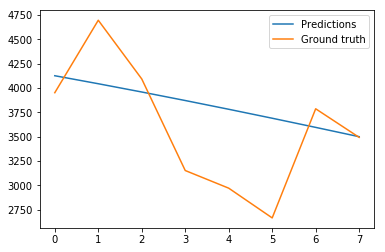

In [19]:
plt.plot(preds, label="Predictions")
plt.plot(test_one_country["cases"].tolist(), label="Ground truth")
plt.legend()

### Run this on all countries

In [20]:
country_list = dataset["countriesAndTerritories"].unique()

In [21]:
loss, params = evaluate_arima_params(timeseries, test_one_country["cases"], [0,1,2], [0,1,2], [0,1,2])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Next cell will take few minutes:

In [22]:
%%capture
predictions = pd.DataFrame()
for country in country_list:
    timeseries = train[train["countriesAndTerritories"] == country]["cases"].tolist()
    test_one_country = test[test["countriesAndTerritories"] == country]
    if len(test_one_country) == 0:
        print(f"There is no test data for {country}")
        continue
    loss, params = evaluate_arima_params(timeseries, test_one_country["cases"], [0,1,2], [0,1,2], [0,1,2])
    if len(timeseries) == 0:
        preds = 0 * len(test_one_country)
    elif len(timeseries) < len(test_one_country):
        preds = timeseries[-1] * len(test_one_country)
    else:
        model = ARIMA(timeseries, order=params)
        model = model.fit(disp=False)
        preds = model.forecast(steps=len(test_one_country))[0]
    test_one_country["predictions"] = preds
    predictions = predictions.append(test_one_country)

### Score on cases:

In [23]:
MSLE_loss(predictions["cases"], predictions["predictions"])

0.6496807493812081